In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
from tqdm import tqdm
from gensim.models import Word2Vec
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import psutil
import time
import pandas as pd


D:\anacevm\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anacevm\pytorch\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\anacevm\pytorch\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable

In [2]:
cpu_count = cpu_count = psutil.cpu_count(logical=False)
if cpu_count > 3:
    cpu_count -= 2
else:
    cpu_count = 1

cpu_count

4

## 读入AnnData数据，var增加一个'gene'列

In [3]:
dataset = 'Stewart_Fetal.h5ad'
#obs4color = 'age'
#mat_type = 'cosim'

In [4]:
adata = sc.read_h5ad('/Stewart_Fetal.h5ad'.format(dataset))
adata

AnnData object with n_obs × n_vars = 26628 × 33694
    obs: 'sample', 'donor', 'gender', 'age-PCW_weeks+days', 'selection', 'cell_type1', 'compartment', 'lifestage', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'ID', 'variable_genes'
    uns: 'age-PCW_weeks+days_colors', 'cell_ontology_class_colors', 'cell_type1_colors', 'compartment_colors', 'data_quality', 'donor_colors', 'gender_colors', 'neighbors', 'sample_colors', 'selection_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [5]:
cell_count = adata.obs['cell_ontology_class'].value_counts()

In [6]:
cell_to_drop = cell_count[cell_count < 100].index

In [7]:
adata = adata[~adata.obs['cell_ontology_class'].isin(cell_to_drop), :]

In [8]:
cell_count2 = adata.obs['cell_ontology_class'].value_counts()

<Axes: xlabel='cell_ontology_class'>

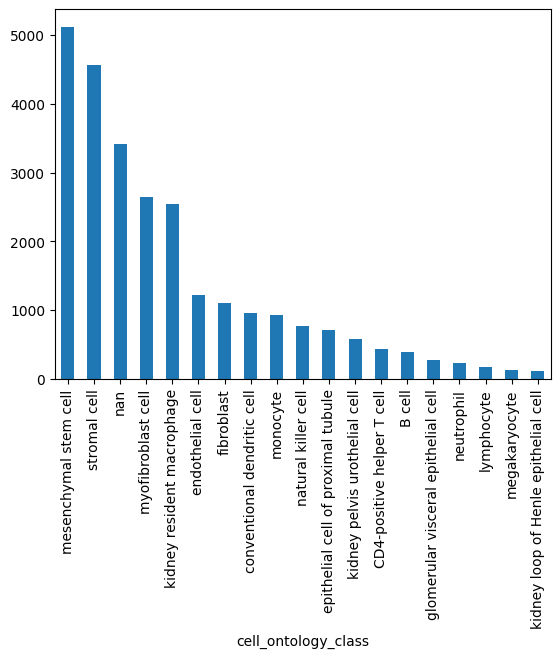

In [9]:
cell_count2.plot(kind='bar')

In [10]:
adata

View of AnnData object with n_obs × n_vars = 26321 × 33694
    obs: 'sample', 'donor', 'gender', 'age-PCW_weeks+days', 'selection', 'cell_type1', 'compartment', 'lifestage', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'ID', 'variable_genes'
    uns: 'age-PCW_weeks+days_colors', 'cell_ontology_class_colors', 'cell_type1_colors', 'compartment_colors', 'data_quality', 'donor_colors', 'gender_colors', 'neighbors', 'sample_colors', 'selection_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [5]:
adata.X

<26628x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 69502183 stored elements in Compressed Sparse Row format>

In [6]:
adata.var['gene'] = adata.var.index

In [7]:
adata.var['gene']

index
RP11-34P13.3    RP11-34P13.3
FAM138A              FAM138A
OR4F5                  OR4F5
RP11-34P13.7    RP11-34P13.7
RP11-34P13.8    RP11-34P13.8
                    ...     
AC233755.2        AC233755.2
AC233755.1        AC233755.1
AC240274.1        AC240274.1
AC213203.1        AC213203.1
FAM231B              FAM231B
Name: gene, Length: 33694, dtype: object

In [8]:
n_cell, n_gene = adata.X.shape

In [9]:
adata.X.shape

(26628, 33694)

In [10]:
#adata.X

In [11]:
adata.X = adata.X.toarray()

In [12]:
adata.X

array([[0.        , 0.        , 0.        , ..., 0.39699864, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.3295219 , 0.        ,
        0.        ]], dtype=float32)

In [13]:
adata.X.shape

(26628, 33694)

## 计算余弦相似度

In [20]:
#cosim = cosine_similarity(adata.X.T)
cosim = np.corrcoef(adata.X.T)


D:\anacevm\pytorch\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\anacevm\pytorch\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [14]:
'''row_means = np.mean(adata.X, axis=1, keepdims=True)
X_centered = adata.X - row_means
adjusted_cosine = np.dot(X_centered, X_centered.T) / (np.linalg.norm(X_centered, axis=1)[:, np.newaxis] * np.linalg.norm(X_centered, axis=1)[np.newaxis, :])
adjusted_cosine'''

array([[0.9999988 , 0.5473684 , 0.7203436 , ..., 0.773568  , 0.00459713,
        0.23919359],
       [0.5473684 , 0.9999986 , 0.31394774, ..., 0.52836704, 0.00313465,
        0.1681633 ],
       [0.7203436 , 0.31394774, 0.9999989 , ..., 0.5034803 , 0.00370413,
        0.17822948],
       ...,
       [0.773568  , 0.52836704, 0.5034803 , ..., 1.0000017 , 0.00601246,
        0.22146797],
       [0.00459713, 0.00313465, 0.00370413, ..., 0.00601246, 0.9999996 ,
        0.9488469 ],
       [0.23919359, 0.1681633 , 0.17822948, ..., 0.22146797, 0.9488469 ,
        1.0000004 ]], dtype=float32)

In [14]:
col_means = np.mean(adata.X, axis=0, keepdims=True)
X_centered = adata.X - col_means
adjusted_cosine = np.dot(X_centered.T, X_centered) / (np.linalg.norm(X_centered, axis = 0)[:, np.newaxis] * np.linalg.norm(X_centered, axis = 0)[np.newaxis, :])

C:\Users\79143\AppData\Local\Temp\ipykernel_6744\980126431.py:3: RuntimeWarning: invalid value encountered in divide
  adjusted_cosine = np.dot(X_centered.T, X_centered) / (np.linalg.norm(X_centered, axis = 0)[:, np.newaxis] * np.linalg.norm(X_centered, axis = 0)[np.newaxis, :])


In [15]:
adjusted_cosine.shape

(33694, 33694)

In [17]:
adjusted_cosine

array([[ 1.00015712e+00, -1.04421015e-04,             nan, ...,
         7.26253400e-03,             nan,             nan],
       [-1.04421015e-04,  1.00002468e+00,             nan, ...,
         1.26999673e-02,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [ 7.26253400e-03,  1.26999673e-02,             nan, ...,
         9.99601781e-01,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]], dtype=float32)

### 对角元取0

In [19]:
for i in range(adjusted_cosine.shape[0]):
    adjusted_cosine[i, i] = 0

In [21]:
adjusted_cosine

array([[0.        , 0.5473684 , 0.7203436 , ..., 0.773568  , 0.00459713,
        0.23919359],
       [0.5473684 , 0.        , 0.31394774, ..., 0.52836704, 0.00313465,
        0.1681633 ],
       [0.7203436 , 0.31394774, 0.        , ..., 0.5034803 , 0.00370413,
        0.17822948],
       ...,
       [0.773568  , 0.52836704, 0.5034803 , ..., 0.        , 0.00601246,
        0.22146797],
       [0.00459713, 0.00313465, 0.00370413, ..., 0.00601246, 0.        ,
        0.9488469 ],
       [0.23919359, 0.1681633 , 0.17822948, ..., 0.22146797, 0.9488469 ,
        0.        ]], dtype=float32)

In [24]:
cosim.shape

(26628, 26628)

In [22]:
cosim = adjusted_cosine

In [23]:
cosim

array([[0.        , 0.5473684 , 0.7203436 , ..., 0.773568  , 0.00459713,
        0.23919359],
       [0.5473684 , 0.        , 0.31394774, ..., 0.52836704, 0.00313465,
        0.1681633 ],
       [0.7203436 , 0.31394774, 0.        , ..., 0.5034803 , 0.00370413,
        0.17822948],
       ...,
       [0.773568  , 0.52836704, 0.5034803 , ..., 0.        , 0.00601246,
        0.22146797],
       [0.00459713, 0.00313465, 0.00370413, ..., 0.00601246, 0.        ,
        0.9488469 ],
       [0.23919359, 0.1681633 , 0.17822948, ..., 0.22146797, 0.9488469 ,
        0.        ]], dtype=float32)

## 随机行走（多进程）

In [14]:
def task_allocation(row_num, cpu_count):
    rand_idx = np.array(list(range(row_num)))
    np.random.shuffle(rand_idx)

    per_cpu = int(row_num / cpu_count)
    row_dict = {}
    for i in range(cpu_count - 1):
        idx_list = list(range(i * per_cpu, i * per_cpu + per_cpu))
        row_dict[i] = [rand_idx[idx] for idx in idx_list]

    idx_list = list(range(idx_list[-1] + 1, row_num - 1))
    row_dict[cpu_count - 1] = [rand_idx[idx] for idx in idx_list]

    return row_dict

row_dict = task_allocation(n_gene, cpu_count)

In [15]:
from multiprocessing import shared_memory, Process
import random_walk

rate = 1.0
#walk_steps = int(n_gene * rate)
walk_steps = 5000

gene_proxim = cosim

cumsum_proxim = np.cumsum(gene_proxim, axis=1)
cumsum_proxim = cumsum_proxim / cumsum_proxim[:, -1].reshape(-1, 1)

gene_corpus = np.zeros((n_gene, walk_steps), dtype=np.int32)

shmr = shared_memory.SharedMemory(create=True, size=cumsum_proxim.nbytes)
np_array = np.ndarray(cumsum_proxim.shape, dtype=cumsum_proxim.dtype, buffer=shmr.buf)
np_array[:] = cumsum_proxim[:]

shmw = shared_memory.SharedMemory(create=True, size=gene_corpus.nbytes)
np_array = np.ndarray(gene_corpus.shape, dtype=gene_corpus.dtype, buffer=shmw.buf)
np_array[:] = gene_corpus[:]

p_list = []
for i in range(cpu_count):
    p_list.append(Process(target=random_walk.random_walk,
                          args=(shmr.name, cumsum_proxim.shape, cumsum_proxim.dtype,
                                shmw.name, gene_corpus.shape, gene_corpus.dtype, walk_steps, row_dict[i])))
    
for p in p_list:
    p.start()
    
for p in p_list:
    p.join()
    
gene_corpus = np.ndarray(gene_corpus.shape, dtype=gene_corpus.dtype, buffer=shmw.buf).copy()

shmr.close()
shmr.unlink()

shmw.close()
shmw.unlink()

C:\Users\79143\AppData\Local\Temp\ipykernel_9696\3891547641.py:11: RuntimeWarning: invalid value encountered in divide
  cumsum_proxim = cumsum_proxim / cumsum_proxim[:, -1].reshape(-1, 1)


In [16]:
gene_corpus

array([[    0,  5468,   353, ..., 16546, 19680, 29530],
       [    1, 23807, 31583, ...,  4129,  5400, 12191],
       [    2,     0,  8789, ..., 25640,  5505, 16972],
       ...,
       [33691, 16348, 30286, ..., 12216, 18349, 19214],
       [33692,     0, 15029, ...,   188,  3914, 20490],
       [33693,     0, 16235, ..., 13283, 24182, 29891]])

In [18]:
gene_corpus.shape

(33694, 3000)

## Word2vec

In [19]:
vector_size = 100
dim = '100'


begin = time.time()
model = Word2Vec(sentences=gene_corpus.tolist(), vector_size=vector_size, min_count=1, workers=cpu_count)
print(time.time() - begin)

282.11203932762146


In [20]:
gene_vec = model.wv.get_normed_vectors()

In [21]:
gene_vec = []

for key in tqdm(model.wv.index_to_key):
    gene_vec.append(model.wv.get_vector(key, norm=False))

gene_vec = np.array(gene_vec)

100%|██████████| 33694/33694 [00:00<00:00, 503889.55it/s]


In [22]:
gene_vec.shape

(33694, 100)

In [12]:
gene_vec

array([[ 3.80422361e-03, -1.63519657e+00, -4.30396461e+00, ...,
        -1.07974350e-01,  4.74461555e+00, -1.10298920e+01],
       [-3.31594288e-01, -5.31213395e-02,  3.96379828e-01, ...,
        -1.44379988e-01,  4.50323462e-01,  1.23571977e-01],
       [-3.36021721e-01,  2.10481994e-02, -5.87985933e-01, ...,
        -1.13437518e-01, -1.75201386e-01,  5.73421121e-01],
       ...,
       [ 1.83395837e-02,  1.01943925e-01,  5.55456430e-02, ...,
        -2.80141067e-02,  6.08552387e-03, -2.86416728e-02],
       [ 2.94519309e-02,  1.30027428e-01,  1.61534414e-01, ...,
         8.14111158e-02,  4.88796718e-02,  1.01589791e-01],
       [-1.18223066e-02,  7.07251653e-02,  1.20244987e-01, ...,
        -1.06869884e-01,  1.52625684e-02,  6.30357340e-02]], dtype=float32)

In [23]:
gene_idx_temp = model.wv.key_to_index

In [24]:
gene_idx_temp = model.wv.key_to_index
gene_idx = {}
for key in gene_idx_temp.keys():
    gene = adata.var.index[key]
    idx = gene_idx_temp[key]
    gene_idx[gene] = idx

In [15]:
reducer = umap.UMAP(random_state=42)
gene_embedding = reducer.fit_transform(gene_vec)

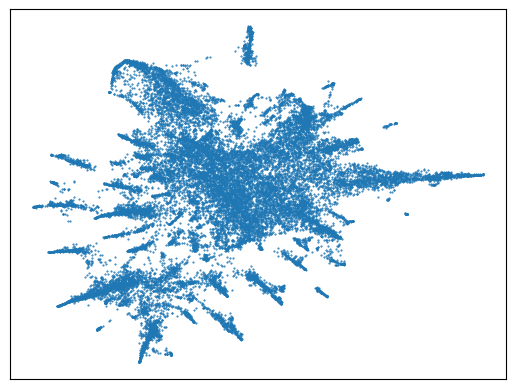

In [16]:
plt.scatter(gene_embedding[:, 0], gene_embedding[:, 1], marker='.', s=1)
plt.xticks([])
plt.yticks([])
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.show()

## 细胞向量

In [27]:
gene_idx

{'A1BG': 0,
 'CALM2': 1,
 'TAGLN2': 2,
 'RPS2': 3,
 'EIF1': 4,
 'RPL3': 5,
 'SKP1': 6,
 'RPL8': 7,
 'TPI1': 8,
 'TPT1': 9,
 'RPL19': 10,
 'RPL5': 11,
 'MYL12B': 12,
 'ATP5B': 13,
 'MYL6': 14,
 'EEF1A1': 15,
 'CFL1': 16,
 'RPL13A': 17,
 'GAPDH': 18,
 'GSTP1': 19,
 'RPL29': 20,
 'RPLP1': 21,
 'RPL13': 22,
 'NACA': 23,
 'B2M': 24,
 'GNB2L1': 25,
 'RPL14': 26,
 'UBC': 27,
 'ATP5G2': 28,
 'RPS3': 29,
 'ALDOA': 30,
 'RPL28': 31,
 'HSP90AB1': 32,
 'EEF1G': 33,
 'HNRNPA2B1': 34,
 'ACTG1': 35,
 'CDC42': 36,
 'SERF2': 37,
 'BTF3': 38,
 'COX4I1': 39,
 'ARPC2': 40,
 'RPL18A': 41,
 'ATP5A1': 42,
 'RHOA': 43,
 'RPS5': 44,
 'UBB': 45,
 'RPL41': 46,
 'GNG5': 47,
 'TMEM59': 48,
 'H3F3B': 49,
 'RPL7A': 50,
 'RPS13': 51,
 'RPL15': 52,
 'PPIB': 53,
 'RPS16': 54,
 'SUMO2': 55,
 'RPL13AP5': 56,
 'YWHAB': 57,
 'HLA-A': 58,
 'PSMA2': 59,
 'SLC25A6': 60,
 'PRDX1': 61,
 'ACTB': 62,
 'NPM1': 63,
 'PPIA': 64,
 'RAC1': 65,
 'TMBIM6': 66,
 'ITM2B': 67,
 'RPS8': 68,
 'RPS7': 69,
 'LDHA': 70,
 'PTGES3': 71,
 'CLIC1':

In [25]:
gene_idx_length = len(gene_idx)
gene_idx_length

33694

In [26]:
gene_vec.shape

(33694, 100)

In [27]:
gene_vec

array([[-0.39121032,  0.16061375,  0.24031745, ..., -0.7018524 ,
        -0.25104725, -0.21383566],
       [-0.16511966,  0.6937094 ,  0.5419009 , ..., -0.5419174 ,
        -0.34595287,  0.24476221],
       [-0.07837516, -0.07126042, -0.44727546, ..., -0.02998968,
         0.15437376, -0.47845596],
       ...,
       [-0.00170602,  0.01063328,  0.02897262, ..., -0.02614314,
         0.00116858,  0.01742938],
       [ 0.00205585,  0.00528047,  0.01977943, ..., -0.00867104,
        -0.01299495,  0.01799508],
       [ 0.00136787, -0.00529838, -0.00311271, ..., -0.0079091 ,
        -0.00950443,  0.00079827]], dtype=float32)

In [28]:
def h5ad2cellvec(ref_gene_idx, ref_gene_vec, h5ad):
    gene_vec = []
    gene_idx = []
    for i in range(len(h5ad.var.index)):
        gene = h5ad.var.index[i]
        if gene in ref_gene_idx.keys():
            ref_idx = ref_gene_idx[gene]
            gene_vec.append(ref_gene_vec[ref_idx])
            gene_idx.append(i)
    gene_vec = np.array(gene_vec)
    
    h5ad = h5ad[:, gene_idx]
    
    cell_vec = []
    for gene_list in tqdm(h5ad.X):
        vec = gene_vec * gene_list.reshape(-1, 1)
        vec = np.sum(vec, axis=0)
        cell_vec.append(vec)
    cell_vec = np.array(cell_vec)
    
    return cell_vec

In [29]:
cell_vec = h5ad2cellvec(gene_idx, gene_vec,adata)

100%|██████████| 26628/26628 [05:15<00:00, 84.36it/s]


In [30]:
cell_vec.shape


(26628, 100)

In [31]:
cell_vec

array([[  333.05905 ,  1879.2731  ,  2825.3992  , ..., -2858.4326  ,
          619.46844 ,  1580.2705  ],
       [  506.82068 ,  1193.3125  ,  2394.0662  , ..., -2303.5269  ,
          312.0524  ,  1985.9624  ],
       [ -185.26428 ,  1846.9799  ,  2415.86    , ..., -3264.5342  ,
          600.0098  ,  1110.1923  ],
       ...,
       [ 1525.7161  ,  1106.7432  ,  2585.4546  , ..., -3825.3772  ,
         1665.7854  ,   235.20236 ],
       [ -243.58595 , -1519.7333  ,  1588.4861  , ..., -2648.253   ,
         1439.8488  , -2187.03    ],
       [ -325.54523 ,   526.06226 ,  1917.8092  , ..., -2972.8271  ,
          521.70264 ,    86.371574]], dtype=float32)

In [22]:
#adata.obs

In [33]:
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm)

In [34]:
cell_norm_vec = h5ad2cellvec(gene_idx, gene_vec, adata_norm)

100%|██████████| 26628/26628 [05:19<00:00, 83.28it/s]


In [35]:
cell_norm_vec

array([[  333.05923 ,  1879.2731  ,  2825.3994  , ..., -2858.433   ,
          619.4685  ,  1580.2705  ],
       [  506.82068 ,  1193.3125  ,  2394.0662  , ..., -2303.5269  ,
          312.0524  ,  1985.9624  ],
       [ -185.26428 ,  1846.9799  ,  2415.86    , ..., -3264.5342  ,
          600.0098  ,  1110.1923  ],
       ...,
       [ 1525.7161  ,  1106.7432  ,  2585.4546  , ..., -3825.3772  ,
         1665.7854  ,   235.20236 ],
       [ -243.58604 , -1519.7335  ,  1588.4863  , ..., -2648.2532  ,
         1439.849   , -2187.0305  ],
       [ -325.54535 ,   526.0624  ,  1917.8094  , ..., -2972.8276  ,
          521.7025  ,    86.371704]], dtype=float32)

In [6]:
obs4color = 'cell_ontology_class'

In [7]:
color_list_520 = np.load('./rainbow_color_520.npy')

def get_category_color(category_list, color_list):
    dn = len(color_list) // len(category_list)
    color_list = [tuple(color_list[i*dn]) for i in range(len(category_list))]
    
    return dict(zip(category_list, color_list))

category_list = list(adata.obs[obs4color].unique())
cate_color = get_category_color(category_list, color_list_520)
cell_color = [cate_color[cate] for cate in adata.obs[obs4color]]

In [11]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

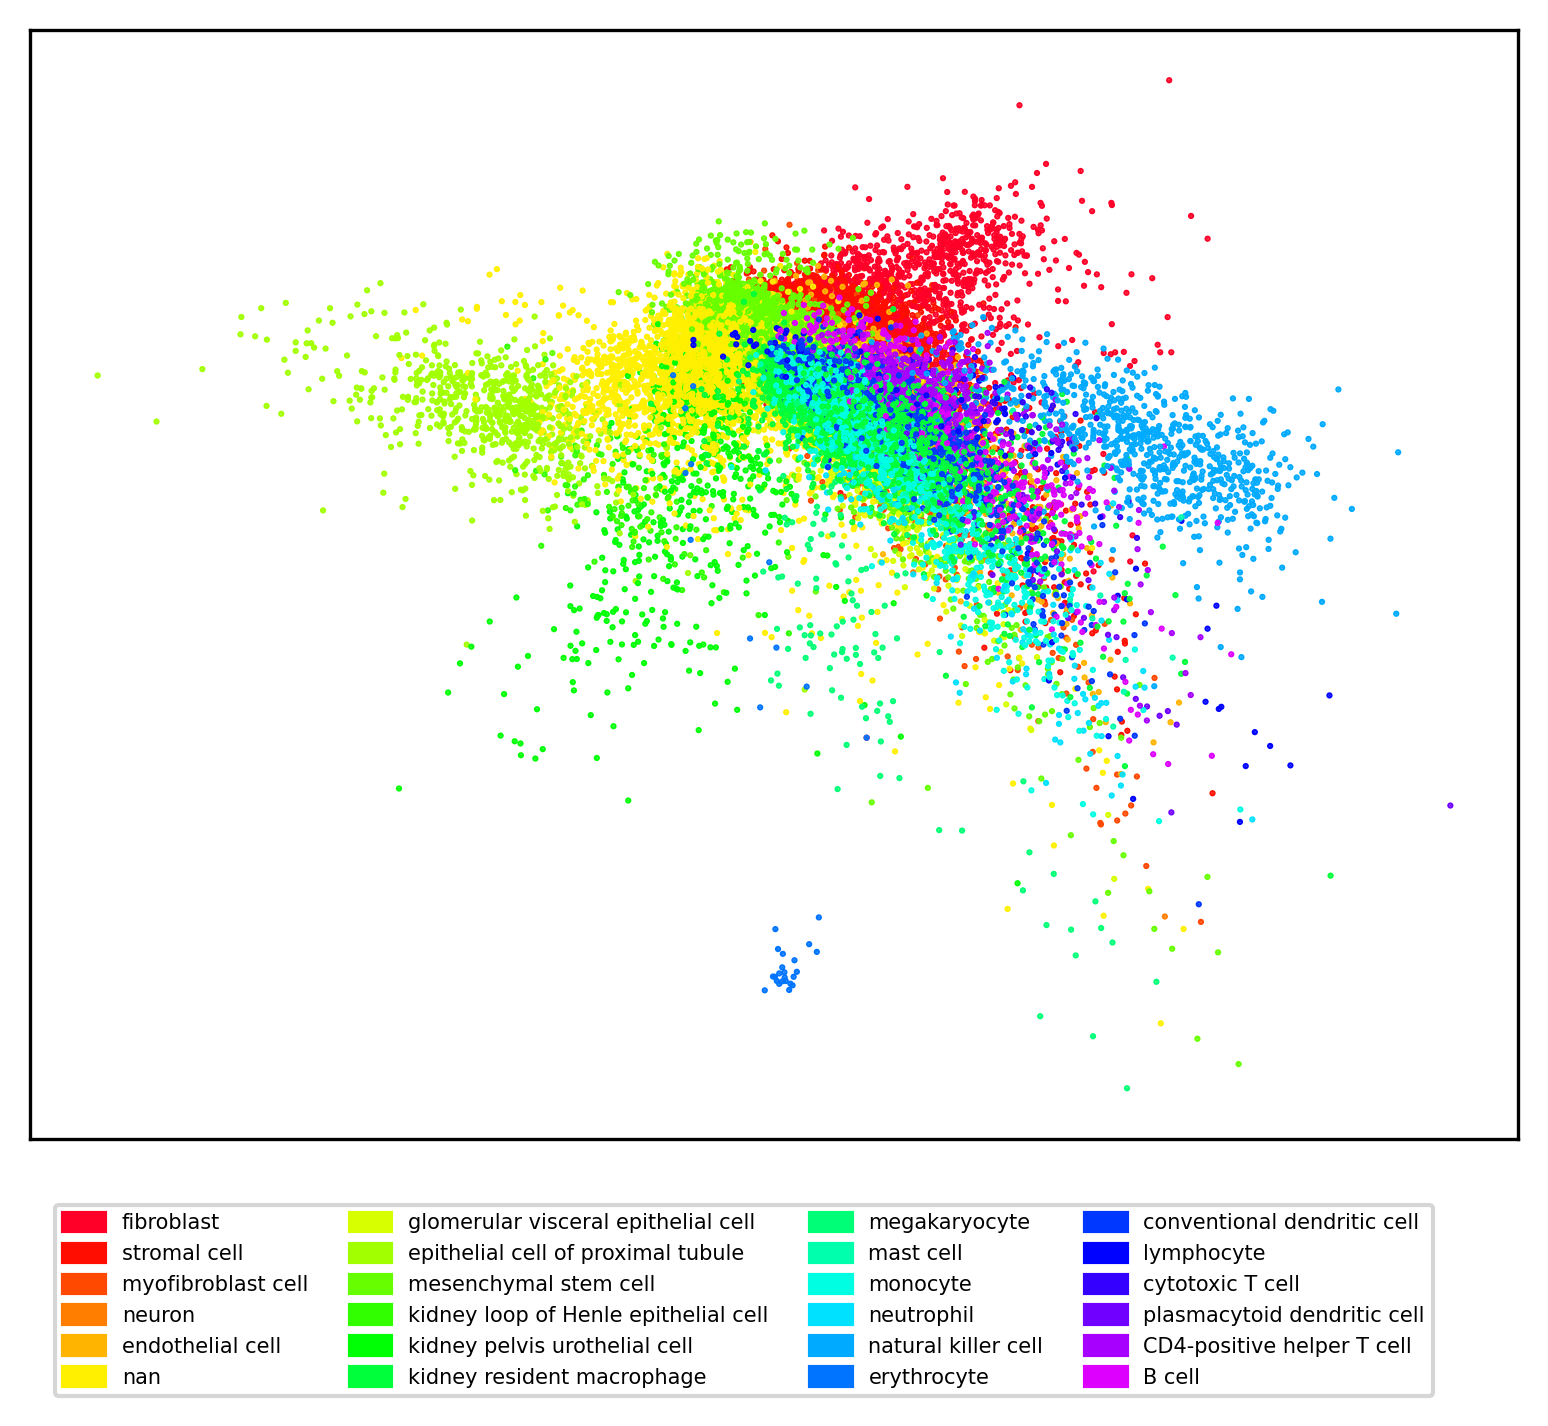

In [20]:
plt.scatter(cell_norm_embedding[:, 0], cell_norm_embedding[:, 1], marker='.', c=cell_color, s=1)

plt.xticks([])
plt.yticks([])
plt.tick_params(bottom=False, top=False, left=False, right=False)

ax=plt.gca()
box = ax.get_position()
patches = [mpatches.Patch(color=cate_color[cate], label=cate) for cate in cate_color.keys()] 

#下面一行中bbox_to_anchor指定了legend的位置
#ax.legend(handles=patches, ncol=1, handleheight=1, bbox_to_anchor=(0.4, 0.95), fontsize=8)
ax.legend(handles=patches, ncol=4, handleheight=1, bbox_to_anchor=(0.95, -0.05), fontsize=5)
plt.show()

# 数据处理

In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
from tqdm import tqdm
#from gensim.models import Word2Vec
#import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
#from sklearn.metrics.pairwise import cosine_similarity
import psutil
import time
import pandas as pd

D:\anacevm\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = 'Stewart_Fetal.h5ad'
adata = sc.read_h5ad('/Stewart_Fetal.h5ad'.format(dataset))
adata

AnnData object with n_obs × n_vars = 26628 × 33694
    obs: 'sample', 'donor', 'gender', 'age-PCW_weeks+days', 'selection', 'cell_type1', 'compartment', 'lifestage', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'ID', 'variable_genes'
    uns: 'age-PCW_weeks+days_colors', 'cell_ontology_class_colors', 'cell_type1_colors', 'compartment_colors', 'data_quality', 'donor_colors', 'gender_colors', 'neighbors', 'sample_colors', 'selection_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs['cell_ontology_class']

cell_id
4834STDY7002875_F16_KI_45P_AAAGCAATCCATGAGT-1             fibroblast
4834STDY7002875_F16_KI_45P_AACGTTGGTAGCTTGT-1           stromal cell
4834STDY7002875_F16_KI_45P_AACTCCCTCTTAGCCC-1           stromal cell
4834STDY7002875_F16_KI_45P_AAGACCTGTAAATGAC-1             fibroblast
4834STDY7002875_F16_KI_45P_AAGTCTGTCCCGGATG-1             fibroblast
                                                        ...         
FCAImmP7579215_F45_KI_45N_TAGTTGGTCGGAATCT-1           megakaryocyte
FCAImmP7579215_F45_KI_45N_TCAGGATCAACGATCT-1                monocyte
FCAImmP7579215_F45_KI_45N_TCGAGGCCATCTATGG-1     natural killer cell
FCAImmP7579215_F45_KI_45N_TGTCCCATCTTGCAAG-1             erythrocyte
FCAImmP7579215_F45_KI_45N_TTTGGTTAGACTGTAA-1             erythrocyte
Name: cell_ontology_class, Length: 26628, dtype: category
Categories (24, object): ['B cell', 'CD4-positive helper T cell', 'conventional dendritic cell', 'cytotoxic T cell', ..., 'neuron', 'neutrophil', 'plasmacytoid dendritic cell'

In [6]:
patient_labels = adata.obs['cell_ontology_class'].unique()
cell_vec_dict = {}
for label in patient_labels:
    cell_vec_dict[label] = []
for i, label in enumerate(adata.obs['cell_ontology_class']):
    cell_vec_dict[label].append(cell_vec[i])
for label in patient_labels:
    cell_vec_dict[label] = np.array(cell_vec_dict[label])

In [7]:
cell_vec_dict

{'fibroblast': array([[  333.05905 ,  1879.2731  ,  2825.3992  , ..., -2858.4326  ,
           619.46844 ,  1580.2705  ],
        [  473.9758  ,  1665.1787  ,  2893.1072  , ..., -2765.117   ,
           503.16238 ,  1466.0306  ],
        [  689.37305 ,  2032.2798  ,  3180.0945  , ..., -2656.7341  ,
           694.7298  ,  1722.444   ],
        ...,
        [   14.603699,  1620.5382  ,  2642.5803  , ..., -3249.5437  ,
           513.4845  ,  1217.0023  ],
        [  604.916   ,  1958.6656  ,  3225.6018  , ..., -2797.9932  ,
           464.44034 ,  1700.5376  ],
        [  190.21884 ,  1907.9532  ,  2715.6375  , ..., -2761.6672  ,
           465.75433 ,  1552.2056  ]], dtype=float32),
 'stromal cell': array([[  506.82068,  1193.3125 ,  2394.0662 , ..., -2303.5269 ,
           312.0524 ,  1985.9624 ],
        [ -185.26428,  1846.9799 ,  2415.86   , ..., -3264.5342 ,
           600.0098 ,  1110.1923 ],
        [  676.51404,   807.0436 ,  2375.8157 , ..., -2248.7979 ,
            86.16768, 

In [8]:
cell_vec_dict['fibroblast']

array([[  333.05905 ,  1879.2731  ,  2825.3992  , ..., -2858.4326  ,
          619.46844 ,  1580.2705  ],
       [  473.9758  ,  1665.1787  ,  2893.1072  , ..., -2765.117   ,
          503.16238 ,  1466.0306  ],
       [  689.37305 ,  2032.2798  ,  3180.0945  , ..., -2656.7341  ,
          694.7298  ,  1722.444   ],
       ...,
       [   14.603699,  1620.5382  ,  2642.5803  , ..., -3249.5437  ,
          513.4845  ,  1217.0023  ],
       [  604.916   ,  1958.6656  ,  3225.6018  , ..., -2797.9932  ,
          464.44034 ,  1700.5376  ],
       [  190.21884 ,  1907.9532  ,  2715.6375  , ..., -2761.6672  ,
          465.75433 ,  1552.2056  ]], dtype=float32)

In [9]:
cell_vec_dict['fibroblast'].shape

(1110, 100)

In [3]:
grouped = adata.obs.groupby(['cell_ontology_class', 'compartment'])['cell_ontology_class'].count()
result_df = grouped.to_frame(name='cell_count').reset_index()
print(result_df)

            cell_ontology_class    compartment  cell_count
0                        B cell    endothelium           0
1                        B cell  fetal_nephron           0
2                        B cell         immune         386
3                        B cell         stroma           0
4    CD4-positive helper T cell    endothelium           0
..                          ...            ...         ...
91  plasmacytoid dendritic cell         stroma           0
92                 stromal cell    endothelium           0
93                 stromal cell  fetal_nephron           0
94                 stromal cell         immune           0
95                 stromal cell         stroma        4558

[96 rows x 3 columns]


In [4]:
result_df_pivot = result_df.pivot(index='cell_ontology_class', columns='compartment', values='cell_count')
print(result_df_pivot)

compartment                           endothelium  fetal_nephron  immune   
cell_ontology_class                                                        
B cell                                          0              0     386  \
CD4-positive helper T cell                      0              0     440   
conventional dendritic cell                     0              0     953   
cytotoxic T cell                                0              0      73   
endothelial cell                             1221              0       0   
epithelial cell of proximal tubule              0            707       0   
erythrocyte                                     0              0      35   
fibroblast                                      0              0       0   
glomerular visceral epithelial cell             0            278       0   
kidney loop of Henle epithelial cell            0            121       0   
kidney pelvis urothelial cell                   0            575       0   
kidney resid

# 向量建立完成，分析

In [10]:
fibroblast = np.sum(cell_vec_dict['fibroblast'], axis=0)
stromal_cell = np.sum(cell_vec_dict['stromal cell'], axis=0)
myofibroblast_cell = np.sum(cell_vec_dict['myofibroblast cell'], axis=0)

#neuron = np.sum(cell_vec_dict['neuron'], axis=0)
endothelial_cell = np.sum(cell_vec_dict['endothelial cell'], axis=0)
#nan = np.sum(cell_vec_dict['nan'], axis=0)

glomerular_visceral  = np.sum(cell_vec_dict['glomerular visceral epithelial cell'], axis=0)
epithelial_cell = np.sum(cell_vec_dict['epithelial cell of proximal tubule'], axis=0)
mesenchymal_stem = np.sum(cell_vec_dict['mesenchymal stem cell'], axis=0)
    
kidney_loop = np.sum(cell_vec_dict['kidney loop of Henle epithelial cell'], axis=0)
kidney_pelvis = np.sum(cell_vec_dict['kidney pelvis urothelial cell'], axis=0)
kidney_resident = np.sum(cell_vec_dict['kidney resident macrophage'], axis=0)

In [12]:
megakaryocyte = np.sum(cell_vec_dict['megakaryocyte'], axis=0)
mast_cell = np.sum(cell_vec_dict['mast cell'], axis=0)
monocyte = np.sum(cell_vec_dict['monocyte'], axis=0)

neutrophil = np.sum(cell_vec_dict['neutrophil'], axis=0)
natural_killer = np.sum(cell_vec_dict['natural killer cell'], axis=0)
erythrocyte = np.sum(cell_vec_dict['erythrocyte'], axis=0)

conventional_dendritic = np.sum(cell_vec_dict['conventional dendritic cell'], axis=0)
lymphocyte = np.sum(cell_vec_dict['lymphocyte'], axis=0)
cytotoxic_T = np.sum(cell_vec_dict['cytotoxic T cell'], axis=0)
    
plasmacytoid_dendritic = np.sum(cell_vec_dict['plasmacytoid dendritic cell'], axis=0)
CD4_positive_helper_T  = np.sum(cell_vec_dict['CD4-positive helper T cell'], axis=0)
B_cell = np.sum(cell_vec_dict['B cell'], axis=0)

In [13]:
vectors = np.array([fibroblast,stromal_cell,myofibroblast_cell,
                    #neuron,nan,
                    endothelial_cell, 
                  glomerular_visceral, epithelial_cell,mesenchymal_stem, kidney_loop,kidney_pelvis,kidney_resident,
                  megakaryocyte, mast_cell ,monocyte,neutrophil,natural_killer ,erythrocyte ,
                  conventional_dendritic ,lymphocyte,cytotoxic_T ,plasmacytoid_dendritic,CD4_positive_helper_T  ,B_cell ])

In [14]:
vectors.shape

(22, 100)

In [15]:
names = ['fibroblast','stromal_cell','myofibroblast_cell',
        # 'neuron', 'nan',
         'endothelial_cell',
                  'glomerular_visceral', 'epithelial_cell','mesenchymal_stem', 'kidney_loop','kidney_pelvis','kidney_resident',
                  'megakaryocyte', 'mast_cell' ,'monocyte','neutrophil','natural_killer' ,'erythrocyte' ,
                  'conventional_dendritic' ,'lymphocyte','cytotoxic_T' ,'plasmacytoid_dendritic','CD4_positive_helper_T' ,'B_cell' ]

In [16]:
distThreshold = 5300000

In [17]:
edges = []
for i in range(22): 
    for j in range(i+1, 22):
         if np.linalg.norm(vectors[i] - vectors[j]) < distThreshold:
                edges.append((i, j))

In [19]:
import igraph as ig
g = ig.Graph()
g.add_vertices(22)
g.add_edges(edges)

In [20]:
node_color_dict = {'fibroblast':'red','stromal_cell':'red','myofibroblast_cell':'red',
                  # 'neuron':'red', 'nan':'yellow',
                   'endothelial_cell':'blue',
                  'glomerular_visceral':'yellow', 'epithelial_cell':'yellow','mesenchymal_stem':'yellow', 
                   'kidney_loop':'yellow','kidney_pelvis':'yellow','kidney_resident':'green',
                  'megakaryocyte':'green', 'mast_cell':'green' ,'monocyte':'green',
                   'neutrophil':'green','natural_killer':'green' ,'erythrocyte':'green' ,
                  'conventional_dendritic' :'green','lymphocyte':'green','cytotoxic_T' :'green',
                   'plasmacytoid_dendritic':'green','CD4_positive_helper_T':'green' ,'B_cell':'green' }

In [21]:
for node in g.vs:
    color = node_color_dict.get(names[node.index])
    node['color'] = color

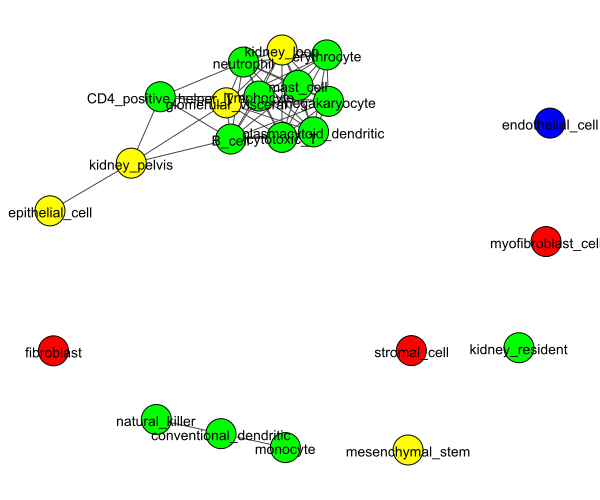

In [32]:
visual_style = {}
visual_style["vertex_label"] = names
#visual_style["vertex_label_dist"] = 2
#visual_style["vertex_label_angle"] = 90
#visual_style['vertex_label_size'] = 20
#visual_style['edge_width'] = 1.0
#visual_style['vertex_frame_width'] = 0.5
#visual_style['vertex_frame_color'] = 'black'
visual_style["vertex_size"] = 30
visual_style["bbox"] = (600, 500)
visual_style["margin"] = 50  # 增加外边距
ig.plot(g, **visual_style)

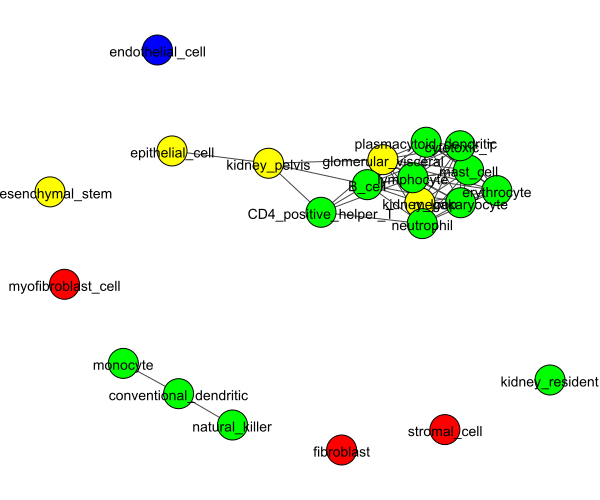

In [35]:
ig.plot(g, 'd:/ACGN/TEST12.png', **visual_style)

In [26]:
np.linalg.norm(vectors[6] - vectors[7])

7705494.0

(10000,)